# Matching vs Regression

**Chapter 10, Section 4**

This notebook compares matching and regression approaches, discussing when to use each.

## Table of Contents
1. [Intuition](#intuition) - Different approaches to adjustment
2. [Formal Treatment](#formal) - Overlap and extrapolation
3. [Numeric Demonstration](#numeric) - Side-by-side comparison
4. [Implementation](#implementation) - Practical guidance
5. [Interview Appendix](#interview) - Practice questions

---

In [1]:
# Standard imports
import sys
sys.path.insert(0, '../..')

from facure_augment.common import *
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

# Set notebook style
set_notebook_style()

print("Imports complete")

Imports complete


---

## Intuition

### Two Philosophies of Adjustment

**Regression** and **Matching** both adjust for confounders, but with different philosophies:

| Aspect | Regression | Matching |
|--------|------------|----------|
| **Approach** | Model the outcome | Find comparable units |
| **Assumption** | Correct functional form | Comparable units exist |
| **With poor overlap** | Extrapolates (silently!) | Fails (transparently) |
| **Efficiency** | Higher if model correct | Lower but robust |

### The Overlap Problem

**Overlap** (common support) means: For every covariate pattern in the treated group, there exist similar control units.

**Regression's weakness**: It extrapolates beyond the data without warning.

**Matching's strength**: It explicitly shows when overlap fails (unmatched units).

---

In [2]:
# Create dataset with overlap problem
np.random.seed(42)
n = 500

# Confounding: older people more likely to get treatment
age = np.random.normal(40, 10, n)
prob_treat = 1 / (1 + np.exp(-(age - 45) / 5))  # Sigmoid: older = more likely
treatment = np.random.binomial(1, prob_treat)

# True effect = 5, with age effect on outcome
true_ate = 5
outcome = 50 + true_ate * treatment + 2 * age + np.random.normal(0, 5, n)

df = pd.DataFrame({
    'age': age,
    'treatment': treatment,
    'outcome': outcome
})

print(f"Data: {n} observations")
print(f"True ATE: {true_ate}")
print(f"Treatment rate: {treatment.mean():.1%}")

Data: 500 observations
True ATE: 5
Treatment rate: 36.0%


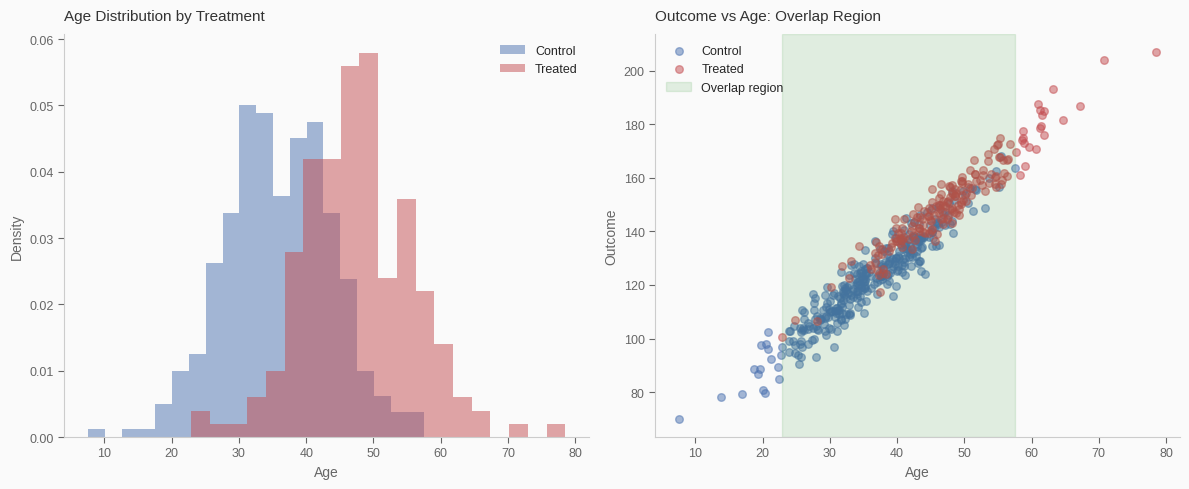

Treated age range: [22.9, 78.5]
Control age range: [7.6, 57.6]
Overlap region: [22.9, 57.6]


In [3]:
# Visualize the overlap situation
fig, axes = create_tufte_figure(ncols=2, figsize=(12, 5))

# Left: Age distribution by treatment
ax = axes[0]
for t, color, label in [(0, COLORS['blue'], 'Control'), (1, COLORS['red'], 'Treated')]:
    subset = df[df['treatment'] == t]
    ax.hist(subset['age'], bins=20, alpha=0.5, color=color, label=label, density=True)

set_tufte_title(ax, "Age Distribution by Treatment")
set_tufte_labels(ax, "Age", "Density")
ax.legend(frameon=False)

# Right: Overlap region
ax = axes[1]
treated_ages = df[df['treatment'] == 1]['age']
control_ages = df[df['treatment'] == 0]['age']

# Common support region
overlap_min = max(treated_ages.min(), control_ages.min())
overlap_max = min(treated_ages.max(), control_ages.max())

ax.scatter(df[df['treatment'] == 0]['age'], df[df['treatment'] == 0]['outcome'], 
           alpha=0.5, c=COLORS['blue'], s=30, label='Control')
ax.scatter(df[df['treatment'] == 1]['age'], df[df['treatment'] == 1]['outcome'], 
           alpha=0.5, c=COLORS['red'], s=30, label='Treated')

# Shade overlap region
ax.axvspan(overlap_min, overlap_max, alpha=0.1, color='green', label='Overlap region')

set_tufte_title(ax, "Outcome vs Age: Overlap Region")
set_tufte_labels(ax, "Age", "Outcome")
ax.legend(frameon=False, loc='upper left')

plt.tight_layout()
plt.show()

print(f"Treated age range: [{treated_ages.min():.1f}, {treated_ages.max():.1f}]")
print(f"Control age range: [{control_ages.min():.1f}, {control_ages.max():.1f}]")
print(f"Overlap region: [{overlap_min:.1f}, {overlap_max:.1f}]")

---

## Formal Treatment

### Regression Extrapolation

Linear regression estimates:

$$Y = \alpha + \tau T + \beta X + \epsilon$$

The treatment effect $\tau$ is **assumed constant** across all values of $X$.

**Problem**: If treated units have $X$ values not seen in controls, regression **extrapolates** the linear relationship.

### Matching: No Extrapolation

Matching only uses **observed** control outcomes:

$$\hat{Y}_i(0) = Y_{j(i)}$$

If no similar control exists, matching fails explicitly (unit is unmatched).

### When Do They Differ?

1. **Overlap is good + linear relationship**: Both give similar results
2. **Overlap is poor**: Regression extrapolates, matching restricts sample
3. **Nonlinear relationship**: Matching is robust, regression may be biased

---

In [4]:
# Estimate with regression
model = smf.ols('outcome ~ treatment + age', data=df).fit()

print("REGRESSION ESTIMATE:")
print("=" * 50)
print(f"Treatment effect: {model.params['treatment']:.2f}")
print(f"SE: {model.bse['treatment']:.2f}")
print(f"95% CI: [{model.conf_int().loc['treatment', 0]:.2f}, {model.conf_int().loc['treatment', 1]:.2f}]")
print(f"\nTrue ATE: {true_ate}")

REGRESSION ESTIMATE:
Treatment effect: 5.40
SE: 0.57
95% CI: [4.28, 6.51]

True ATE: 5


In [5]:
# Estimate with matching
def matching_estimate(df, outcome_col, treatment_col, features):
    """1-NN matching estimator."""
    X = df[features].values
    Y = df[outcome_col].values
    T = df[treatment_col].values
    
    # Split
    X_treated = X[T == 1]
    X_control = X[T == 0]
    Y_treated = Y[T == 1]
    Y_control = Y[T == 0]
    
    # Standardize
    scaler = StandardScaler()
    X_control_std = scaler.fit_transform(X_control)
    X_treated_std = scaler.transform(X_treated)
    
    # Match
    nn = NearestNeighbors(n_neighbors=1)
    nn.fit(X_control_std)
    distances, indices = nn.kneighbors(X_treated_std)
    
    # Counterfactuals
    counterfactuals = Y_control[indices.flatten()]
    effects = Y_treated - counterfactuals
    
    return {
        'ATT': effects.mean(),
        'SE': effects.std() / np.sqrt(len(effects)),
        'mean_distance': distances.mean(),
        'n_treated': len(Y_treated)
    }

match_result = matching_estimate(df, 'outcome', 'treatment', ['age'])

print("\nMATCHING ESTIMATE (full sample):")
print("=" * 50)
print(f"ATT: {match_result['ATT']:.2f}")
print(f"SE: {match_result['SE']:.2f}")
print(f"95% CI: [{match_result['ATT'] - 1.96*match_result['SE']:.2f}, {match_result['ATT'] + 1.96*match_result['SE']:.2f}]")


MATCHING ESTIMATE (full sample):
ATT: 6.17
SE: 0.64
95% CI: [4.92, 7.42]


---

## Numeric Demonstration

### Creating an Extreme Overlap Problem

In [6]:
# Create data with severe overlap problem
np.random.seed(123)
n = 500

# Treatment almost perfectly determined by age threshold
age = np.random.normal(40, 10, n)
# Treated: mostly older, Control: mostly younger
treatment = (age > 45).astype(int)
# Add some noise to avoid perfect separation
flip_idx = np.random.choice(n, size=int(0.1*n), replace=False)
treatment[flip_idx] = 1 - treatment[flip_idx]

# Outcome with nonlinear age effect
true_ate = 5
outcome = 50 + true_ate * treatment + 0.5 * (age - 40)**2 + np.random.normal(0, 5, n)

df_poor = pd.DataFrame({
    'age': age,
    'treatment': treatment,
    'outcome': outcome
})

print("POOR OVERLAP DATA:")
print(f"Treated mean age: {df_poor[df_poor['treatment']==1]['age'].mean():.1f}")
print(f"Control mean age: {df_poor[df_poor['treatment']==0]['age'].mean():.1f}")
print(f"Age gap: {df_poor[df_poor['treatment']==1]['age'].mean() - df_poor[df_poor['treatment']==0]['age'].mean():.1f} years")

POOR OVERLAP DATA:
Treated mean age: 47.9
Control mean age: 35.2
Age gap: 12.6 years


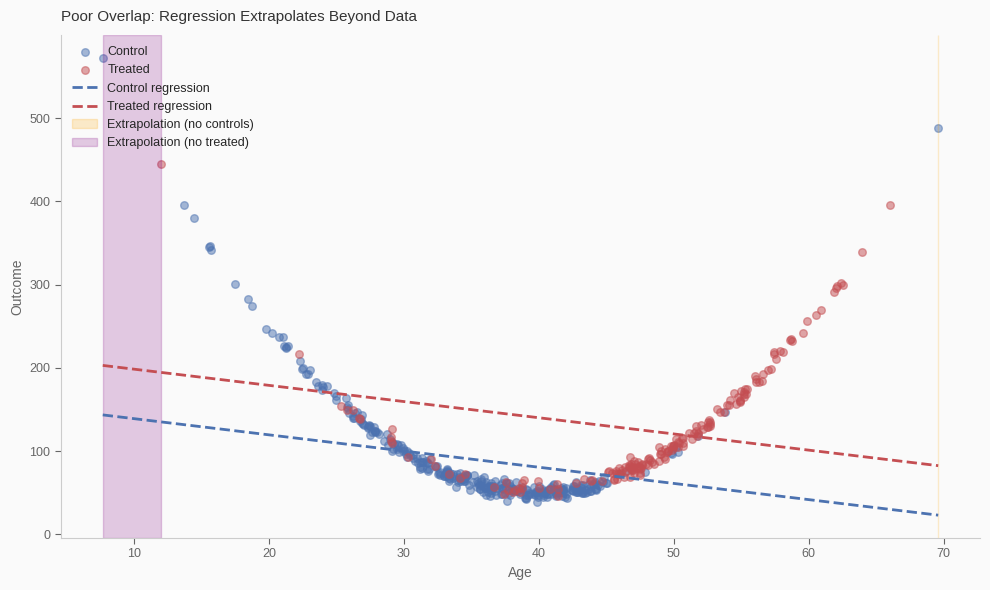

In [7]:
# Visualize poor overlap
fig, ax = create_tufte_figure(figsize=(10, 6))

ax.scatter(df_poor[df_poor['treatment'] == 0]['age'], 
           df_poor[df_poor['treatment'] == 0]['outcome'], 
           alpha=0.5, c=COLORS['blue'], s=30, label='Control')
ax.scatter(df_poor[df_poor['treatment'] == 1]['age'], 
           df_poor[df_poor['treatment'] == 1]['outcome'], 
           alpha=0.5, c=COLORS['red'], s=30, label='Treated')

# Add regression lines (will extrapolate)
ages_range = np.linspace(df_poor['age'].min(), df_poor['age'].max(), 100)
model_poor = smf.ols('outcome ~ treatment + age', data=df_poor).fit()
ax.plot(ages_range, model_poor.params['Intercept'] + model_poor.params['age'] * ages_range,
        color=COLORS['blue'], linewidth=2, linestyle='--', label='Control regression')
ax.plot(ages_range, model_poor.params['Intercept'] + model_poor.params['treatment'] + model_poor.params['age'] * ages_range,
        color=COLORS['red'], linewidth=2, linestyle='--', label='Treated regression')

# Mark extrapolation region
treated_ages = df_poor[df_poor['treatment'] == 1]['age']
control_ages = df_poor[df_poor['treatment'] == 0]['age']
ax.axvspan(control_ages.max(), df_poor['age'].max(), alpha=0.2, color='orange', 
           label='Extrapolation (no controls)')
ax.axvspan(df_poor['age'].min(), treated_ages.min(), alpha=0.2, color='purple',
           label='Extrapolation (no treated)')

set_tufte_title(ax, "Poor Overlap: Regression Extrapolates Beyond Data")
set_tufte_labels(ax, "Age", "Outcome")
ax.legend(frameon=False, loc='upper left', fontsize=9)

plt.tight_layout()
plt.show()

In [8]:
# Compare estimates on poor overlap data
print("ESTIMATES WITH POOR OVERLAP:")
print("=" * 60)
print(f"True ATE: {true_ate}")

# Naive
naive = df_poor[df_poor['treatment']==1]['outcome'].mean() - df_poor[df_poor['treatment']==0]['outcome'].mean()
print(f"\nNaive (no adjustment): {naive:.2f} (biased due to age confounding)")

# Regression (linear)
reg_linear = smf.ols('outcome ~ treatment + age', data=df_poor).fit()
print(f"\nRegression (linear age):")
print(f"  Effect: {reg_linear.params['treatment']:.2f} (SE: {reg_linear.bse['treatment']:.2f})")

# Regression (quadratic) - correct specification
reg_quad = smf.ols('outcome ~ treatment + age + I(age**2)', data=df_poor).fit()
print(f"\nRegression (quadratic age):")
print(f"  Effect: {reg_quad.params['treatment']:.2f} (SE: {reg_quad.bse['treatment']:.2f})")

# Matching
match_poor = matching_estimate(df_poor, 'outcome', 'treatment', ['age'])
print(f"\nMatching (1-NN):")
print(f"  ATT: {match_poor['ATT']:.2f} (SE: {match_poor['SE']:.2f})")
print(f"  Mean match distance: {match_poor['mean_distance']:.2f} std units")

ESTIMATES WITH POOR OVERLAP:
True ATE: 5

Naive (no adjustment): 34.84 (biased due to age confounding)

Regression (linear age):
  Effect: 59.43 (SE: 7.80)

Regression (quadratic age):
  Effect: 4.87 (SE: 0.58)

Matching (1-NN):
  ATT: 6.94 (SE: 3.31)
  Mean match distance: 0.14 std units


In [9]:
# Restrict to common support and re-estimate
treated_ages = df_poor[df_poor['treatment'] == 1]['age']
control_ages = df_poor[df_poor['treatment'] == 0]['age']

# Common support
cs_min = max(treated_ages.min(), control_ages.min())
cs_max = min(treated_ages.max(), control_ages.max())

df_cs = df_poor[(df_poor['age'] >= cs_min) & (df_poor['age'] <= cs_max)].copy()

print(f"\nCOMMON SUPPORT ANALYSIS:")
print("=" * 60)
print(f"Original sample: {len(df_poor)} observations")
print(f"Common support: [{cs_min:.1f}, {cs_max:.1f}]")
print(f"Restricted sample: {len(df_cs)} observations ({len(df_cs)/len(df_poor)*100:.1f}%)")

# Regression on common support
if len(df_cs) > 10:  # Ensure enough data
    reg_cs = smf.ols('outcome ~ treatment + age', data=df_cs).fit()
    print(f"\nRegression (common support):")
    print(f"  Effect: {reg_cs.params['treatment']:.2f} (SE: {reg_cs.bse['treatment']:.2f})")
    
    match_cs = matching_estimate(df_cs, 'outcome', 'treatment', ['age'])
    print(f"\nMatching (common support):")
    print(f"  ATT: {match_cs['ATT']:.2f} (SE: {match_cs['SE']:.2f})")


COMMON SUPPORT ANALYSIS:
Original sample: 500 observations
Common support: [12.0, 66.0]
Restricted sample: 498 observations (99.6%)

Regression (common support):
  Effect: 63.94 (SE: 7.15)



Matching (common support):
  ATT: 20.64 (SE: 2.96)


---

## Implementation

### Practical Guidance

In [10]:
# Summary comparison table
print("PRACTICAL COMPARISON: MATCHING vs REGRESSION")
print("=" * 70)
print(f"\n{'Criterion':<25} {'Regression':<20} {'Matching':<20}")
print("-" * 70)
print(f"{'Functional form':<25} {'Required (specified)':<20} {'Not required':<20}")
print(f"{'Overlap handling':<25} {'Extrapolates silently':<20} {'Fails explicitly':<20}")
print(f"{'Efficiency (good spec)':<25} {'Higher':<20} {'Lower':<20}")
print(f"{'Robustness':<25} {'Sensitive to spec':<20} {'More robust':<20}")
print(f"{'Sample size needed':<25} {'Smaller':<20} {'Larger':<20}")
print(f"{'High dimensions':<25} {'Handles well':<20} {'Struggles (curse)':<20}")
print(f"{'Transparency':<25} {'Lower':<20} {'Higher':<20}")

PRACTICAL COMPARISON: MATCHING vs REGRESSION

Criterion                 Regression           Matching            
----------------------------------------------------------------------
Functional form           Required (specified) Not required        
Overlap handling          Extrapolates silently Fails explicitly    
Efficiency (good spec)    Higher               Lower               
Robustness                Sensitive to spec    More robust         
Sample size needed        Smaller              Larger              
High dimensions           Handles well         Struggles (curse)   
Transparency              Lower                Higher              


In [11]:
# Decision flowchart
print("\nWHEN TO USE EACH METHOD:")
print("=" * 70)
print("""
1. START with MATCHING if:
   - You want to see overlap explicitly
   - You're unsure about functional form
   - You have enough data for good matches
   
2. USE REGRESSION if:
   - You have strong theory about functional form
   - Sample size is limited
   - Many covariates (curse of dimensionality)
   
3. BEST PRACTICE: Use BOTH as robustness checks
   - If results agree: More confidence
   - If results differ: Investigate why
     * Check overlap
     * Check functional form assumptions
     * Consider propensity score methods
""")


WHEN TO USE EACH METHOD:

1. START with MATCHING if:
   - You want to see overlap explicitly
   - You're unsure about functional form
   - You have enough data for good matches

2. USE REGRESSION if:
   - You have strong theory about functional form
   - Sample size is limited
   - Many covariates (curse of dimensionality)

3. BEST PRACTICE: Use BOTH as robustness checks
   - If results agree: More confidence
   - If results differ: Investigate why
     * Check overlap
     * Check functional form assumptions
     * Consider propensity score methods



In [12]:
# Final comparison on original (good overlap) data
print("\nFINAL ESTIMATES (original data with good overlap):")
print("=" * 70)
print(f"True ATE: {5}")
print(f"\n{'Method':<30} {'Estimate':<12} {'SE':<12} {'95% CI'}")
print("-" * 70)

# Regression
reg = smf.ols('outcome ~ treatment + age', data=df).fit()
print(f"{'Regression (linear)':<30} {reg.params['treatment']:<12.2f} {reg.bse['treatment']:<12.2f} [{reg.conf_int().loc['treatment', 0]:.2f}, {reg.conf_int().loc['treatment', 1]:.2f}]")

# Matching
m = matching_estimate(df, 'outcome', 'treatment', ['age'])
print(f"{'Matching (1-NN)':<30} {m['ATT']:<12.2f} {m['SE']:<12.2f} [{m['ATT']-1.96*m['SE']:.2f}, {m['ATT']+1.96*m['SE']:.2f}]")

print(f"\nBoth methods recover the true effect when overlap is good!")


FINAL ESTIMATES (original data with good overlap):
True ATE: 5

Method                         Estimate     SE           95% CI
----------------------------------------------------------------------
Regression (linear)            5.40         0.57         [4.28, 6.51]


Matching (1-NN)                6.17         0.64         [4.92, 7.42]

Both methods recover the true effect when overlap is good!


---

## Interview Appendix

### Practice Questions

**Q1: When would you prefer matching over regression?**

<details>
<summary>Solution</summary>

**Prefer matching when**:

1. **Uncertain about functional form**: Matching is nonparametric, so it doesn't assume linearity or any specific relationship.

2. **Concerned about overlap**: Matching explicitly shows which units can be matched, making overlap problems visible.

3. **Want transparency**: Matching shows exactly which units are compared, making the analysis more interpretable.

4. **Moderate number of covariates**: With 2-5 continuous covariates, matching works well.

**Prefer regression when**:

1. **Strong theory about functional form**: If you know the relationship is linear, regression is more efficient.

2. **Many covariates**: Regression handles high dimensions better than matching (curse of dimensionality).

3. **Limited sample size**: Regression needs fewer observations to be stable.

**Best practice**: Use both and compare. If they agree, you have more confidence. If they disagree, investigate why.

</details>

**Q2: What is the overlap problem and how does matching handle it differently than regression?**

<details>
<summary>Solution</summary>

**Overlap (Common Support)** means every covariate pattern has both treated and control units:

$$0 < P(T=1|X=x) < 1 \quad \forall x$$

**When overlap fails**:
- Some treated units have no comparable controls
- Treatment effect is not identified for those units

**Regression's approach**:
- **Extrapolates** beyond observed data
- Uses fitted model to predict counterfactuals
- Gives estimates even without overlap
- **Problem**: Extrapolation is unreliable and hidden

**Matching's approach**:
- **Fails explicitly** when overlap is poor
- Unmatched units are visible
- Only uses observed control outcomes
- **Benefit**: Forces analyst to confront overlap problem

**Key insight**: Regression silently extrapolates; matching loudly fails. Both tell you something important about your data.

</details>

**Q3: How would you use matching and regression together as robustness checks?**

<details>
<summary>Solution</summary>

**Strategy**:

1. **Run both methods** on the same data
2. **Compare estimates**

**If estimates agree**:
- More confidence in the result
- Functional form assumptions probably reasonable
- Overlap is likely adequate

**If estimates differ, investigate**:

1. **Check overlap**:
   - Plot covariate distributions by treatment
   - Calculate propensity scores and check common support
   - Restrict regression to common support region

2. **Check functional form**:
   - Add nonlinear terms to regression
   - Check residual plots
   - Try flexible specifications (splines, polynomials)

3. **Report both estimates** with explanation of differences

**Diagnostic pattern**:
- Regression higher than matching → May be extrapolating upward
- Matching higher than regression → May have poor matches or misspecification

</details>

---

## References

[^1]: Facure, M. (2022). *Causal Inference for the Brave and True*, Chapter 10.

[^2]: King, G., & Zeng, L. (2006). The dangers of extreme counterfactuals. *Political Analysis*, 14(2), 131-159.

[^3]: Ho, D. E., Imai, K., King, G., & Stuart, E. A. (2007). Matching as nonparametric preprocessing for reducing model dependence in parametric causal inference. *Political Analysis*, 15(3), 199-236.

[^4]: Cross-reference: Propensity score methods in `11_propensity_score/`